In [1]:
from ipynb.fs.full.deck_visualization import visualize_deck as vd
import random, copy

# Provide a non-interactive short ZK argument that shows that you have solved a Sudoku-like puzzle: Jigsaw Sudoku

For this assignment, we have updated the following paper's protocol: https://www.tains.tohoku.ac.jp/netlab/mizuki/conf/zerosuno_fct2023_web.pdf, so it would be applicable to Jigsaw Sudoku.

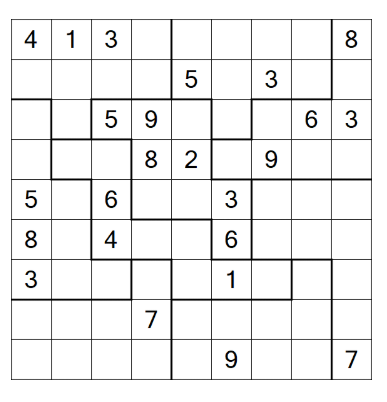

Our idea is to use "new type" of cards. This cards, whould have 3 different sides:
- backside of a card (no information)
- number from 1-9 and a color from: Yellow, Red, Blue
- number from 1-9

In physical implementation we could use a device which would hide 2 side of the card, and with rotation we could diclose other sides of the card.
E.g.: card is 9; ?; 9Y; the device is on it's empty side, if we rotate to left, we would get the number side, if we rotate to the right side we would get the number and color side.





For Jigsaw Sudoku we have to redefine what we call a block, how can we identify them, and calculate with them.

For the computation, we mark ever block with it's own unique identifier letter ( a-i ). Identifying the order of the blocks:
A block's top row's, leftest number will be the identifying cell.

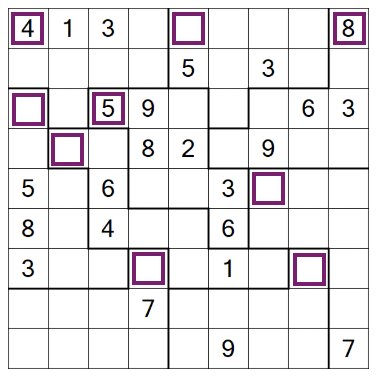

The 9 block give us 9 different cells: from left to right and from top to bottom, we give an identifying letter to each block.

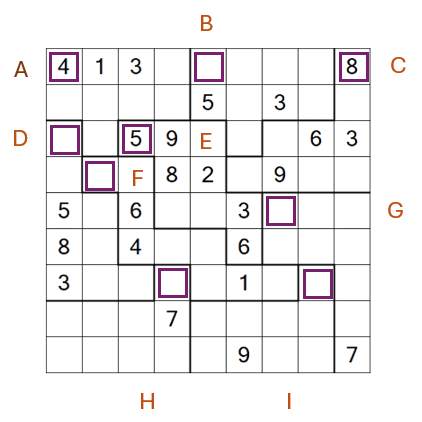

Both the Prover and the Verifier knows about the block identifying process, and we even want the Prover to give the solution with the block identification.

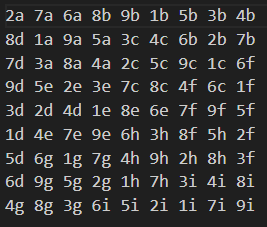


## Step 1: Get a Jigsaw Sudoku

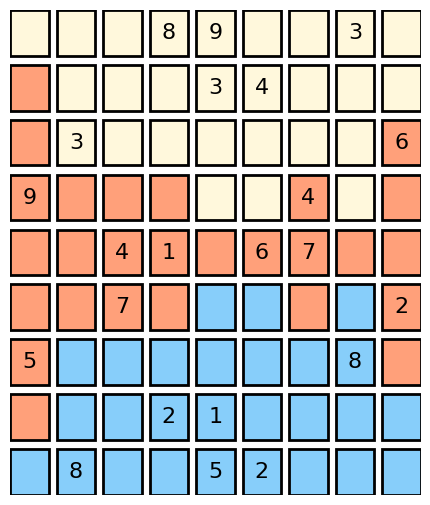

In [2]:
# a-b-c Yellow
# d-e-f Red
# g-h-i Blue

table = open("jigsaw_sudoku/01.txt", "r")
table = table.read()
deck = []
blocks =[] # store the placement of the blocks

for idx, row in enumerate(table.split('\n')):
    temp = []
    for idy, x in enumerate(row.split(' ')):
        blocks.append(x[1])
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
    deck.append(temp)
vd(deck)

## Step 1.1: A Prover (P) commits a solution

The Prover (P) has to provide a solution for the given task.

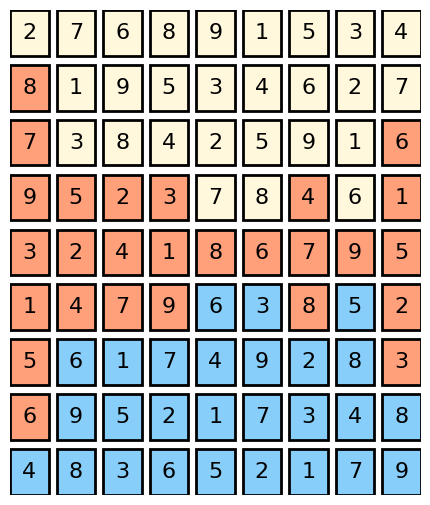

In [3]:
# a-b-c Yellow
# d-e-f Red
# g-h-i Blue

table = open("jigsaw_sudoku/01_sol.txt", "r")
table = table.read()
deck = []
for idx, row in enumerate(table.split('\n')):
    temp = []
    for idy, x in enumerate(row.split(' ')):
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
    deck.append(temp)
vd(deck)

## Preliminaries

### Pile-Scramble Shuffle

Divide the deck to $k$ subgrups, then shuffle them randomly.

In [4]:
def pile_shuffle(deck, k):
    split_by_k = []
    k_temp = 0
    temp = []
    for card in deck:
        temp.append(card)
        k_temp += 1
        if k_temp == k:
            split_by_k.append(temp)
            temp = []
            k_temp = 0
    
    return [card for pile in random.sample(split_by_k, len(split_by_k)) for card in pile]

### Uniqueness Verification Protocol

In [5]:
# Helper functions


# Given 2 arrays, merge them into a single array by alternating elements from each array
# Example:
# deck1: [1,2,3]
# deck2: [4,5,6]
# result: [1,4,2,5,3,6]
def merge_decks(deck1, deck2):
    temp = []
    for x in range(0, len(deck1)):
        temp.append(deck1[x])
        temp.append(deck2[x])
    return temp


# Given a deck, split it into 2 decks by alternating elements from the original deck
# Example:
# deck: [1,4,2,5,3,6]
# deck1: [1,2,3]
# deck2: [4,5,6]
def split_decks(deck):
    deck1 = []
    deck2 = []
    for idx, card in enumerate(deck):
        if idx % 2 == 0:
            deck1.append(card)
        else:
            deck2.append(card)
    return deck1, deck2


# Create a "?" row with a given number of columns
# Example:
# empty_row(2)
# [{"number": "?", "color": "white"}, {"number": "?", "color": "white"}]
def empty_row(num):
    return [{"number": "?", "color": "white"} for _ in range(0, num)]

In [6]:
# Uniqueness Ver. Prot. with Visualizing the Deck (vd)
def unique_with_vd(deck, checker):
    k = len(deck)
    # Create the helper deck with numbers 1-9
    help_deck = []
    for x in range(1,len(deck)+1):
        help_deck.append({"number": x, "color": "white"})

    # We need to merge the normal and the helping deck
    # so we can shuffle them together by pairs (k = 2)
    print('Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once')
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, deck2 = split_decks(merged) # we just have to split it, so we can draw it out
    vd([deck1, empty_row(k)])

    # Here we check if 1-9 cards are present only once of each color
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print('There is a duplicate in the deck or an unexpected card.')
            print('Problematic card:', x)
            print('Remaining checker:', checker)
            return False

    # We have to shuffle again, so won't know the orders
    print('Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state')
    deck1, deck2 = split_decks(pile_shuffle(merged, 2))
    vd([empty_row(k), deck2])

    # We have to sort the revealed helping deck, so we can restore the original sequence
    print("Sort the helping deck, so the row is restored to the original sequence without knowing the exact order")
    paired_decks = list(zip(deck1, deck2))
    sorted_paired_decks = sorted(paired_decks, key=lambda x: x[1]['number'])
    sorted_deck1, sorted_deck2 = zip(*sorted_paired_decks)
    sorted_deck2 = list(sorted_deck2)

    #vd([sorted_deck1, sorted_deck2])
    vd([empty_row(k), sorted_deck2])

    return True

In [7]:
# This is the same as the unique_with_vd function, but without the visualization
def unique(deck, checker):
    # Creating the helper deck
    help_deck = []
    for x in range(1, len(deck) + 1):
        help_deck.append({"number": x, "color": "white"})

    # Merging the decks and shuffling them
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, _ = split_decks(merged)

    # Here we check if 1-9 cards are present only once of each color
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print("There is a duplicate in the deck or an unexpected card.")
            print("Problematic card:", x)
            print("Remaining checker:", checker)
            return False
    return True

## Helper vector 

In [13]:
a = [
    [{"number": i, "color": "white"} for i in range(1, 10)],
    [{"number": i, "color": "cornsilk"} for i in range(1, 10)],
    [{"number": i, "color": "lightsalmon"} for i in range(1, 10)],
    [{"number": i, "color": "lightskyblue"} for i in range(1, 10)],
]

## Sub-protocols

### Row Verification Sub-protocol

In [14]:
def row_ver(deck):
    for i in range(0, 9):
        row = [{"number": x["number"], "color": "white"} for x in deck[i]]
        checker = copy.deepcopy(a)
        checker = checker[0]
        if not unique(row, checker):
            print("Duplicate number in row")
            print(row)
            return False
    return True


row_ver(deck)

True

### Column Verification Sub-protocol

In [15]:
def col_ver(deck):
    for i in range(0, 9):
        col = [{"number": row[i]["number"], "color": "white"} for row in deck]
        checker = copy.deepcopy(a)
        checker = checker[0]
        if not unique(col, checker):
            print("Duplicate number in column")
            print(col)
            return False
    return True


col_ver(deck)

True

### Color Verification Sub-protocol

### 3-block Verification Sub-protocol

# The protocol for 9x9 Jigsaw Sudoku

> This is the proposed protocol for convincing a verifier that the numbers 1 to 9 appear exactly once in each row, each column, and each block.